<center><h1>Bangalore House price prediction</h1></center>

In [1]:
'''Importing libraries'''
'''general lib for data manipulation'''
import pandas as pd                                     #dataframe manipulation
import numpy as np                                      #numerical computation
'''viz lib'''
import matplotlib.pyplot as plt                         #visualization library for plotting
%matplotlib inline                                      
import matplotlib                                       #visualization library
matplotlib.rcParams['figure.figsize'] = (20,10)         #to specify the figure size of the plot shown
'''advanced mathematical computation lib'''
from sklearn.model_selection import GridSearchCV        #hyperparameter tuning to compare accuracies of models
from sklearn.linear_model import Lasso                  #lasso regression model function
from sklearn.tree import DecisionTreeRegressor          #DT regression model function
from sklearn.model_selection import train_test_split    #to split the dataset for training and testing datasets
from sklearn.linear_model import LinearRegression       #linear regression model function
from sklearn.model_selection import ShuffleSplit        #to split train and test dataset randomly
from sklearn.model_selection import cross_val_score     #to generate the average cross validation of training sets
print('All libraries imported')

All libraries imported


In [2]:
'''Reading data from CSV file'''
df = pd.read_csv('Bengaluru_House_Data.csv')
df.head() #to view data

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### Exploratory data analysis(EDA)

In [3]:
#df.columns
#df.info()
#df.describe()
#df.isnull().sum()
#df.groupby('area_type')['area_type'].agg('count')

In [4]:
df = df.drop(['area_type','society','availability','balcony'], axis=1)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [5]:
#df.shape
#df.isnull().sum()

In [6]:
df.dropna(inplace=True)

### Feature Engineering

In [7]:
#df['size'].unique()

In [8]:
df['BHK'] = df['size'].apply(lambda x: float(x.split()[0]))
df.drop('size', axis=1, inplace=True)

In [9]:
#df.head()
#df.info()
#df['bath'].unique()


In [10]:
'''I need to look at the dataset of size where the `total_sqft` entries cannot be directly converted to float dtype'''
def float_check(x):
    try :
        float(x)
        return False
    except:
        return True
df[df['total_sqft'].apply(float_check)].head()

,location,total_sqft,bath,price,BHK
30,Yelahanka,2100 - 2850,4.0,186.000,4.0
122,Hebbal,3067 - 8156,4.0,477.000,4.0
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2.0
165,Sarjapur,1145 - 1340,2.0,43.490,2.0
188,KR Puram,1015 - 1540,2.0,56.800,2.0


In [11]:
'''Function to remove the inconsistent values and bringing out mean of range values'''
def to_float(x):
    try:
        if '-' in x:
            m = x.split('-')
            if len(m) == 2:
                return (float(m[0]) + float(m[1]))/2
        else :
            return float(x)
    except :
        return None

In [12]:
df['total_sqft'] = df['total_sqft'].apply(to_float)

In [13]:
#df.isnull().sum()
df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13200 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13200 non-null  object 
 1   total_sqft  13200 non-null  float64
 2   bath        13200 non-null  float64
 3   price       13200 non-null  float64
 4   BHK         13200 non-null  float64
dtypes: float64(4), object(1)
memory usage: 618.8+ KB


Dimentionality Reduction to be conducted to reduce the less frequent locations in the sample 

In [15]:
'''We need to reduce any whitespace in the `location` column'''
df['location'].unique()
#df['location'] = df['location'].apply(lambda x: x.strip())

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

In [16]:
freq = df['location'].value_counts(ascending=False)
infreq = freq[freq<=10]

In [17]:
df['location'] = df['location'].apply(lambda x: 'other' if x in infreq else x)
#len(df['location'].unique())
'''Number of unique locations reduced from 1200's to 241'''

"Number of unique locations reduced from 1200's to 241"

In [18]:
#df.head()
df['ppsqft'] = df['price']/df['total_sqft']*100000
df.head()

,location,total_sqft,bath,price,BHK,ppsqft
0,Electronic City Phase II,1056.0,2.0,39.07,2.0,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4.0,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3.0,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3.0,6245.890861
4,Kothanur,1200.0,2.0,51.00,2.0,4250.000000


In [19]:
df = df[df['total_sqft']/df['BHK'] >= 300]
'''Assuming 1BHK flat cannot be less than 300, other entries have to removed'''

'Assuming 1BHK flat cannot be less than 300, other entries have to removed'

In [20]:
df.describe()#.loc['std']['total_sqft']

,total_sqft,bath,price,BHK,ppsqft
count,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000
mean,1590.189927,2.562781,111.187960,2.649004,6308.502826
std,1260.404795,1.080275,152.203367,0.976046,4168.127339
min,300.000000,1.000000,9.000000,1.000000,267.829813
25%,1115.000000,2.000000,49.000000,2.000000,4210.526316
50%,1300.000000,2.000000,70.000000,3.000000,5294.117647
75%,1700.000000,3.000000,115.000000,3.000000,6916.666667
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [21]:
'''This method shouldn't be applied because mean and stdev shall be considered of every location instead of the whole dataset'''
#df1 = df[(df['ppsqft'] >= df.describe().loc['mean']['total_sqft']-df.describe().loc['std']['total_sqft']) &(df['ppsqft'] <= df.describe().loc['mean']['total_sqft']+df.describe().loc['std']['total_sqft'])]

"This method shouldn't be applied because mean and stdev shall be considered of every location instead of the whole dataset"

In [22]:
def remove_pps_outliers(df) :
    df1 = pd.DataFrame()
    for loc, subdf in df.groupby('location') :
        m = np.mean(subdf['ppsqft'])
        std = np.std(subdf['ppsqft'])
        rdf = subdf[(subdf['ppsqft'] >= (m-std)) & (subdf['ppsqft'] <= (m+std))]
        df1 = pd.concat([df1,rdf], ignore_index=True)
    return df1

In [23]:
df = remove_pps_outliers(df)

### Data Visualization

In [24]:
def plot_scatter(df, location):
    bhk2 = df[(df['location'] == location) & (df['BHK'] == 2)]
    bhk3 = df[(df['location'] == location) & (df['BHK'] == 3)]
    matplotlib.rcParams['figure.figsize'] = (8,6)
    plt.scatter(bhk2['total_sqft'], bhk2['price'], c='blue', s=50)
    plt.scatter(bhk3['total_sqft'], bhk3['price'], c='green', s=50, marker='+')
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Total Price')
    plt.title(location)
    plt.legend()

No handles with labels found to put in legend.


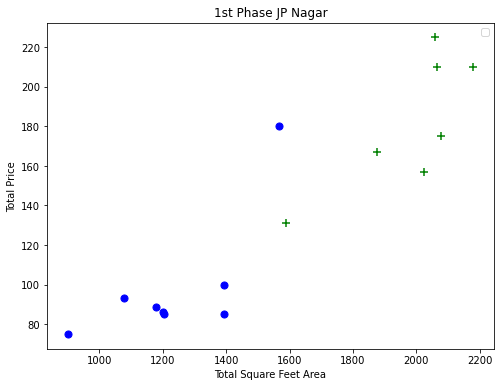

In [25]:
plot_scatter(df, '1st Phase JP Nagar')

Text(0, 0.5, 'count')

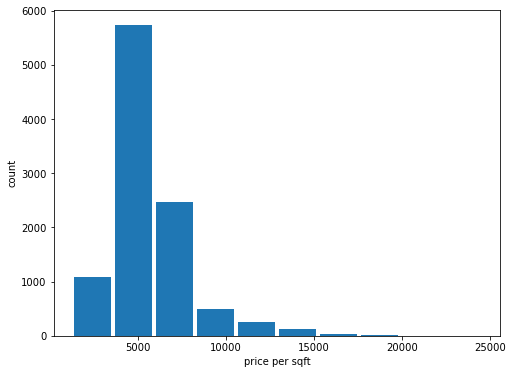

In [26]:
'''Plotting the price per square feet vs count'''
plt.hist(df['ppsqft'], rwidth=0.9)
plt.xlabel('price per sqft')
plt.ylabel('count')

Text(0, 0.5, 'Count')

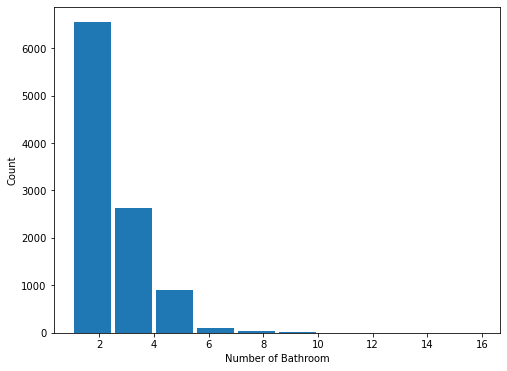

In [27]:
'''Plotting the histogram for bathroom vs Count'''
plt.hist(df['bath'], rwidth=0.9)
plt.xlabel('Number of Bathroom')
plt.ylabel('Count')

In [28]:
df[df['bath']>10]

,location,total_sqft,bath,price,BHK,ppsqft
5271,Neeladri Nagar,4000.0,12.0,160.0,10.0,4000.000000
8478,other,12000.0,12.0,525.0,10.0,4375.000000
8567,other,10000.0,16.0,550.0,16.0,5500.000000
9307,other,6000.0,12.0,150.0,11.0,2500.000000
9639,other,5425.0,13.0,275.0,13.0,5069.124424


In [29]:
'''So it is unusual to have 2 more bathrooms than the bedroom'''
df = df[df['bath']<df['BHK']+2]

Using One hot coding on location

In [30]:
dummies = pd.get_dummies(df['location'])
dummies.head()

,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df1 = pd.concat([df, dummies.drop('other', axis='columns')], axis='columns')

In [32]:
df1 = df1.drop('location', axis=1)

In [33]:
'''Here is the training set for the further machine learning'''
X = df1.drop('price', axis='columns')

In [34]:
'''Here is the test set for the further machine learning'''
y = df1['price']

In [35]:
X.shape, y.shape

((10151, 244), (10151,))

### Train Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [37]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.9001832175729708

In [38]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.90072659, 0.84479428, 0.93114656, 0.94788837, 0.91345072])